In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
# import xgboost as xgb
%matplotlib inline

In [2]:
data= pd.read_csv('/kaggle/input/indian-liver-patient-records/indian_liver_patient.csv')

**REPLACING MISSING VALUES WITH MICE**

In [3]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Assuming you have your dataset loaded into 'data'

# Select the columns with missing values that you want to impute
columns_to_impute = ['Albumin_and_Globulin_Ratio']

# Create an IterativeImputer instance
imputer = IterativeImputer(random_state=42)

# Fit the imputer on your data
imputer.fit(data[columns_to_impute])

# Transform the original 'data' DataFrame to impute missing values in place
data[columns_to_impute] = imputer.transform(data[columns_to_impute])

# Now, 'data' contains the imputed values using the MICE method
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  583 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


# TYPE ENCODING: "Gender: Male=1, Female=0" & "Liver_Patient=1, Not_Liver_Patient=0"

In [4]:
data['Gender']=data['Gender'].apply(lambda x:1 if x=='Male' else 0)
data['Dataset'] = data['Dataset'].map({2:0,1:1})

# DATA STANDARDIZATION

In [5]:
# Existing import statements
from sklearn.preprocessing import StandardScaler

# ... (previous parts of the code)

#******* DATA STANDARDIZATION USING STANDARD SCALER *******

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the features and transform both the training and testing set
data_scaled = scaler.fit_transform(data.drop(['Dataset'], axis=1))

# Create a DataFrame from the scaled data
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.drop(['Dataset']))

# Replace original DataFrame's features with standardized features
data[data.columns.drop(['Dataset'])] = data_scaled

# The DataFrame 'data' is now standardized
print(data.head())


        Age    Gender  Total_Bilirubin  Direct_Bilirubin  \
0  1.252098 -1.762281        -0.418878         -0.493964   
1  1.066637  0.567446         1.225171          1.430423   
2  1.066637  0.567446         0.644919          0.931508   
3  0.819356  0.567446        -0.370523         -0.387054   
4  1.684839  0.567446         0.096902          0.183135   

   Alkaline_Phosphotase  Alamine_Aminotransferase  Aspartate_Aminotransferase  \
0             -0.426715                 -0.354665                   -0.318393   
1              1.682629                 -0.091599                   -0.034333   
2              0.821588                 -0.113522                   -0.145186   
3             -0.447314                 -0.365626                   -0.311465   
4             -0.393756                 -0.294379                   -0.176363   

   Total_Protiens   Albumin  Albumin_and_Globulin_Ratio  Dataset  
0        0.292120  0.198969                   -0.147898        1  
1        0.937566 

# DATA BALANCING using Normal Upsampling

**Minority Upsamling**

In [6]:
data.Dataset.value_counts()

Dataset
1    416
0    167
Name: count, dtype: int64

In [7]:
# Split data on majority and minority.. minority is dataset == 0
minority = data[data.Dataset==0]
majority = data[data.Dataset==1]

print('Minority size:', minority.shape)
print('Majority size:', majority.shape)

Minority size: (167, 11)
Majority size: (416, 11)


In [8]:
# choosing upsample as even now we do not have too much data
minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
print('Minority upsampled size:', minority_upsample.shape)

Minority upsampled size: (416, 11)


In [9]:
# merge majority with upsampled minority
data = pd.concat([minority_upsample, majority], axis=0)

In [10]:
# Display the modified DataFrame
print(data)

          Age    Gender  Total_Bilirubin  Direct_Bilirubin  \
471  0.262974 -1.762281        -0.434996         -0.493964   
342 -0.602508  0.567446        -0.402760         -0.458327   
327 -1.282531  0.567446         0.000194          0.040588   
305  0.572075 -1.762281        -0.306051         -0.280143   
512  0.695716  0.567446        -0.370523         -0.422690   
..        ...       ...              ...               ...   
576 -0.787969  0.567446         1.886015          2.392617   
577 -0.787969  0.567446         1.515298          2.463891   
579 -0.293407  0.567446        -0.434996         -0.493964   
580  0.448435  0.567446        -0.402760         -0.458327   
581 -0.849789  0.567446        -0.322169         -0.351417   

     Alkaline_Phosphotase  Alamine_Aminotransferase  \
471             -0.434955                 -0.349185   
342             -0.381397                 -0.245055   
327             -0.480273                 -0.382068   
305             -0.393756          

# DATA SPLIT

**Train/Test=80%/20%**

In [11]:
X=data.iloc[:,:-1]

y = data['Dataset']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Applying LDA

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to your training data
lda.fit(X_train, y_train)  # Assuming you have class labels y_train

# Determine the number of components to retain
explained_variances_lda = lda.explained_variance_ratio_
cumulative_variances_lda = np.cumsum(explained_variances_lda)
threshold_lda = 0.95
num_components_lda = np.argmax(cumulative_variances_lda >= threshold_lda) + 1

# Applying LDA
lda = LinearDiscriminantAnalysis(n_components=num_components_lda)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)


# CLASSIFIER MODEL BUILDING

# RF updated

Accuracy Score: 0.8383233532934131
AUC-ROC Score: 0.8698550724637681


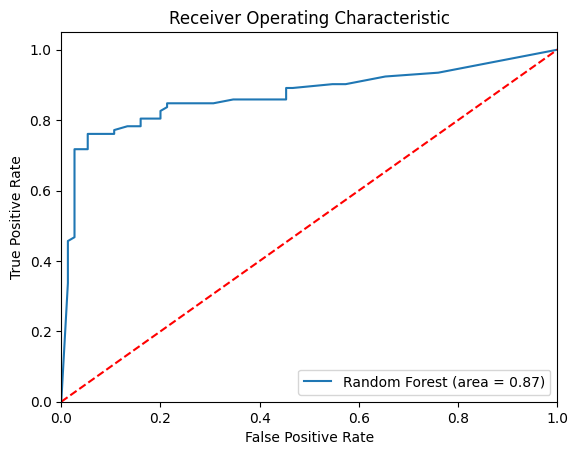

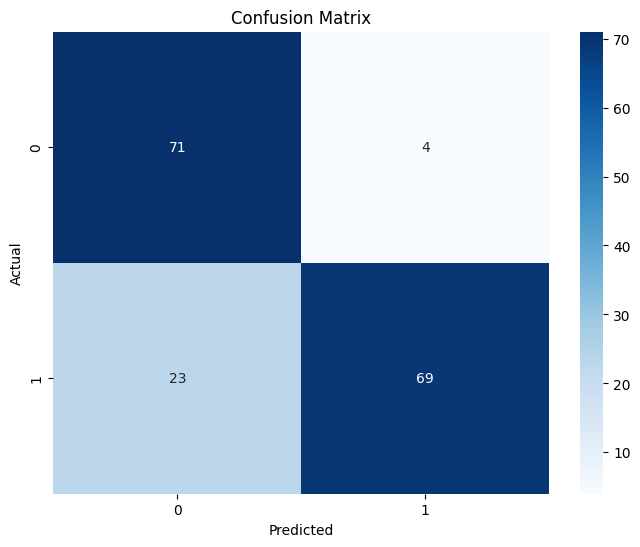

In [13]:
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# Calculate and print the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", roc_auc)

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**RF with GridSearch**

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Best AUC-ROC Score: 0.7981541412551643
Best Accuracy: 0.7664670658682635
Best AUC-ROC Score: 0.8431884057971014


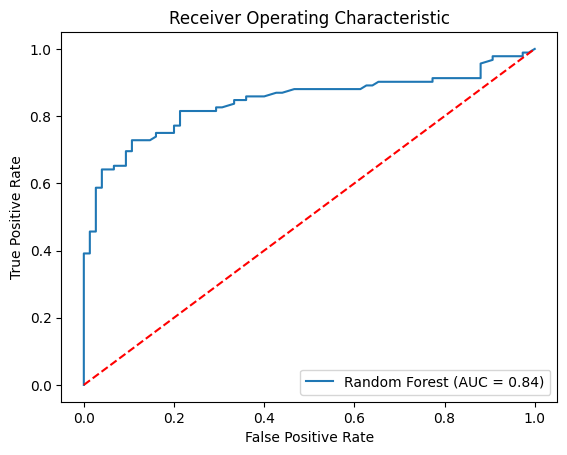

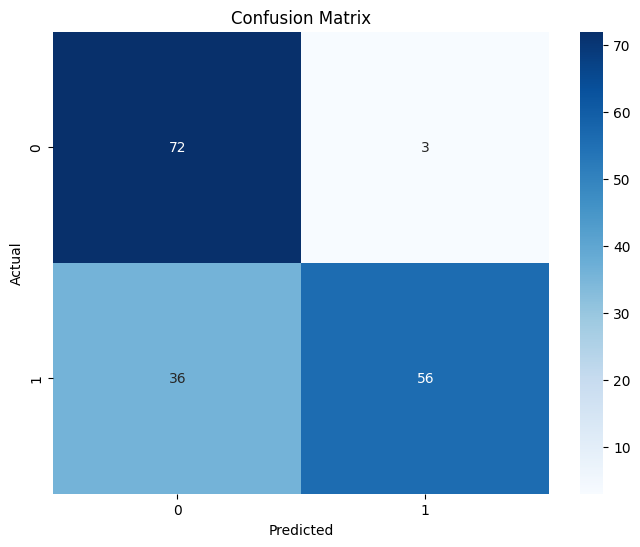

In [14]:
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, y_train, X_test, and y_test are already defined

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get best parameters and best AUC score
best_params = grid_search.best_params_
best_auc_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC-ROC Score:", best_auc_score)

# Evaluate using the best hyperparameters
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Best Accuracy
best_accuracy = accuracy_score(y_test, y_pred)
print("Best Accuracy:", best_accuracy)

# Best AUC-ROC score
best_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best AUC-ROC Score:", best_roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
best_conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**RF with FS & GS**

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Best AUC-ROC Score: 0.7981541412551643
Accuracy: 0.7664670658682635
AUC-ROC: 0.8431884057971014


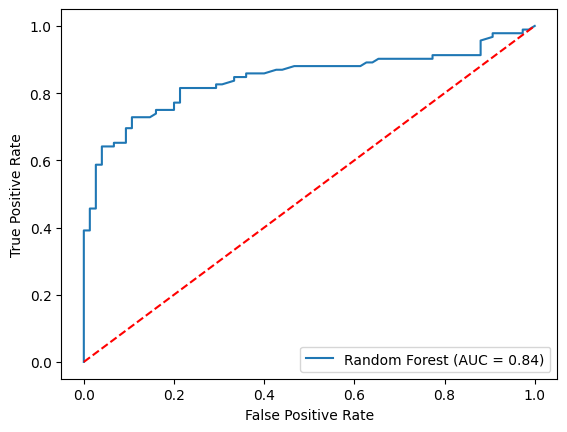

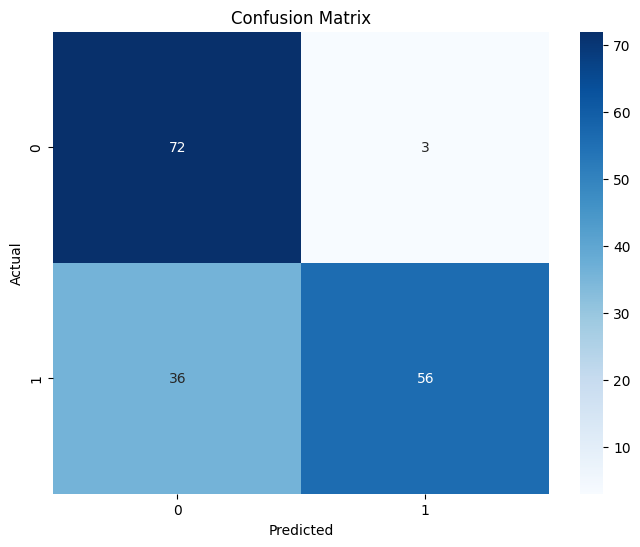

In [15]:
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train, y_train, X_test, and y_test are already defined

# Step 1: Initial feature importance evaluation using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order and get the indices
sorted_idx = np.argsort(importances)[::-1]

# Select top important features, let's say top 5 for this example
top_5_idx = sorted_idx[:5]  # Get the indices of the top 5 features

# Directly use the indices if X_train and X_test are numpy arrays
X_train_selected = X_train[:, top_5_idx]
X_test_selected = X_test[:, top_5_idx]

# Step 2: Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_selected, y_train)

# Get best parameters and best AUC score
best_params = grid_search.best_params_
best_auc_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best AUC-ROC Score:", best_auc_score)

# Step 3: Evaluation using the best hyperparameters
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# XGB updated

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy Score: 0.7664670658682635
AUC-ROC Score: 0.8553623188405798


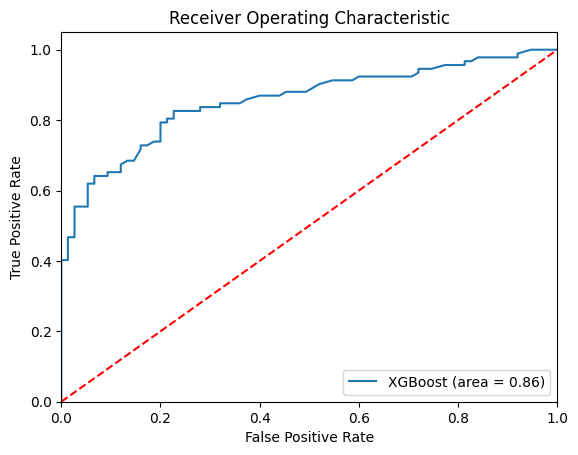

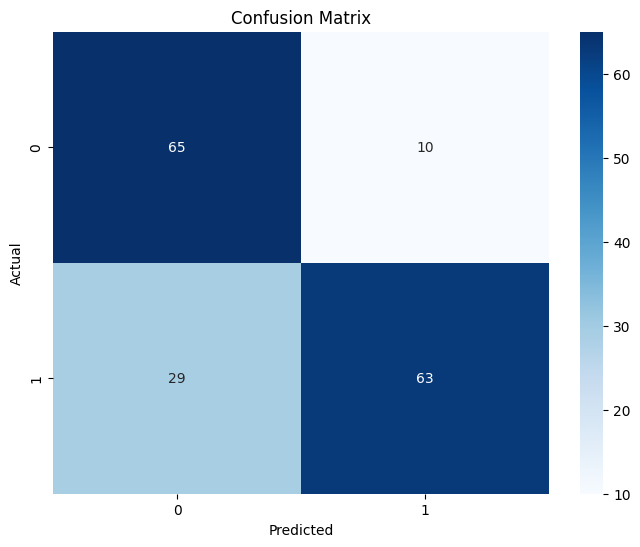

In [16]:
# Import necessary modules
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is imported for the heatmap

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# Calculate and print the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", roc_auc)

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**XGB with GS**

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Accuracy Score: 0.7604790419161677
Best AUC-ROC Score: 0.8442028985507246


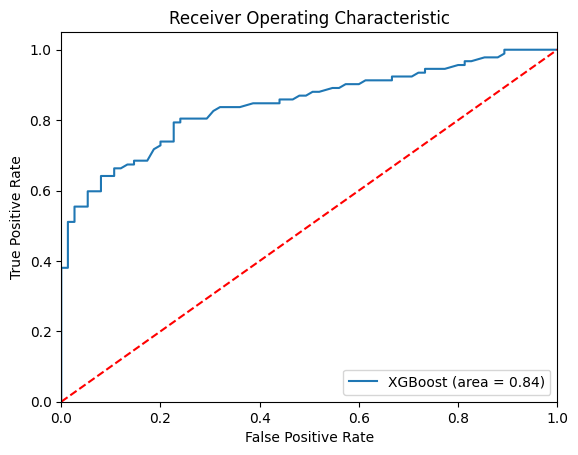

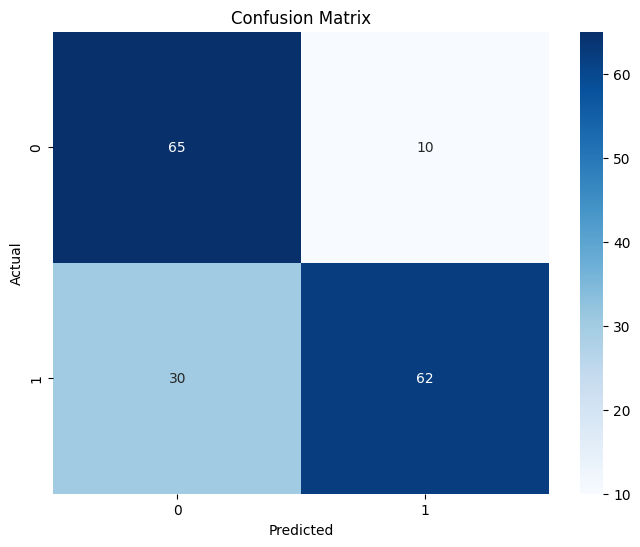

In [17]:
# Import necessary modules
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the hyper-parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='roc_auc', verbose=2)

# Perform hyper-parameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyper-parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Best Accuracy Score:", accuracy)

# Calculate and print the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best AUC-ROC Score:", roc_auc)

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**XGB with FS & GS**

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}
Accuracy Score: 0.7425149700598802
AUC-ROC Score: 0.8405797101449276


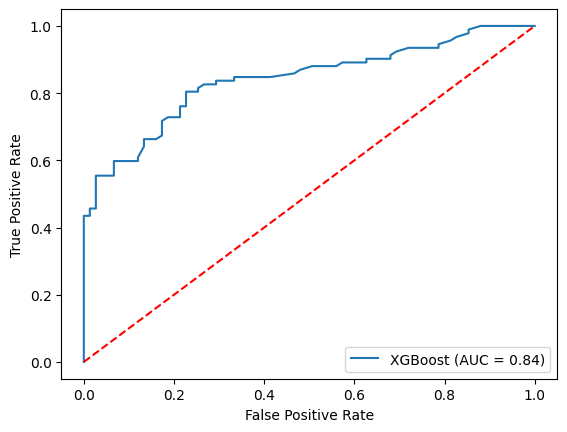

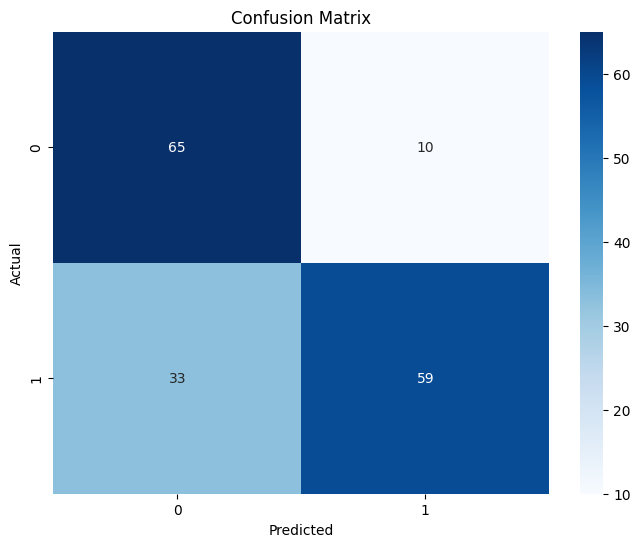

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train, y_train, X_test, y_test are defined

# Feature Selection using XGBoost
xgb_for_feature_selection = XGBClassifier(random_state=42)
xgb_for_feature_selection.fit(X_train, y_train)
sorted_idx = np.argsort(xgb_for_feature_selection.feature_importances_)[::-1]

# Select top important features, let's say top 5 for this example
top_5_idx = sorted_idx[:5]  # Get the indices of the top 5 features

# Directly index NumPy array
X_train_selected = X_train[:, top_5_idx]
X_test_selected = X_test[:, top_5_idx]

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)

# Grid Search parameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train_selected, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions
y_pred = grid_search.predict(X_test_selected)
y_pred_proba = grid_search.predict_proba(X_test_selected)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# CART updated

Accuracy of CART: 0.8383233532934131
ROC-AUC Score: 0.8483333333333334


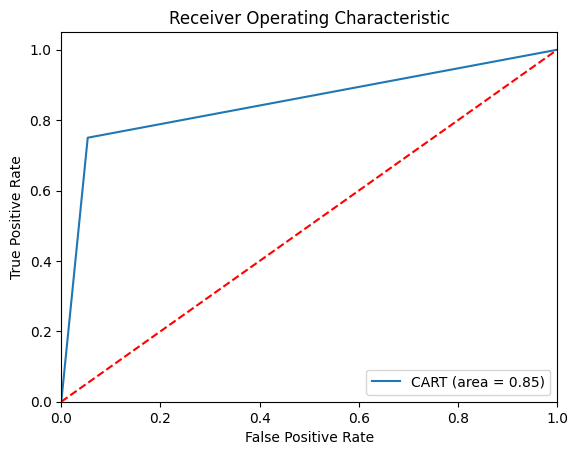

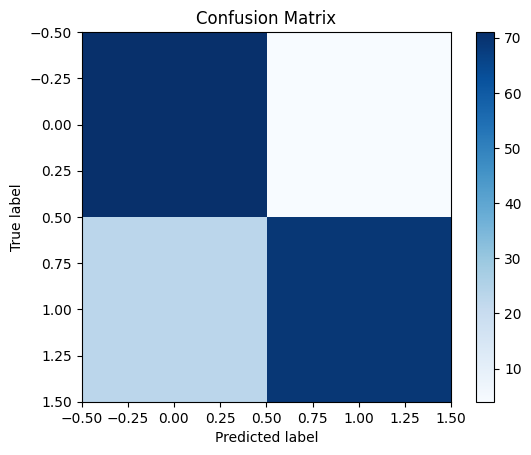

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize Decision Tree Classifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the model
cart_model.fit(X_train, y_train)

# Make predictions
y_pred = cart_model.predict(X_test)
y_pred_proba = cart_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of CART: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='CART (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**CART with GS**

Accuracy of tuned CART: 0.8083832335329342
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'splitter': 'best'}
ROC-AUC Score: 0.8369565217391305


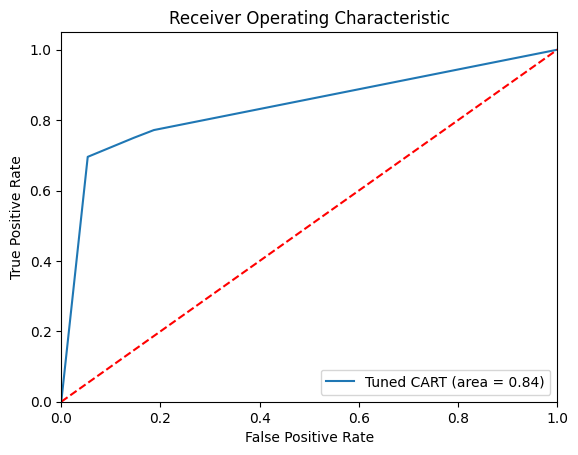

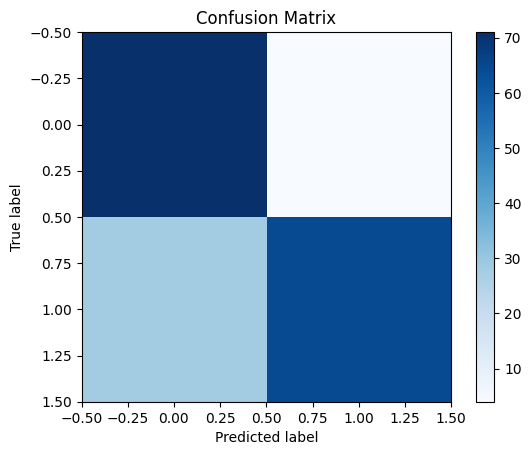

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize Decision Tree Classifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Parameter grid
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [10, 20, 30],
              'min_samples_split': [2, 5, 10]}

# Initialize GridSearchCV
grid_search = GridSearchCV(cart_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of tuned CART: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Tuned CART (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**CART_FS_GS**

Accuracy of feature-selected and tuned CART: 0.8083832335329342
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'splitter': 'best'}
ROC-AUC Score: 0.8369565217391305


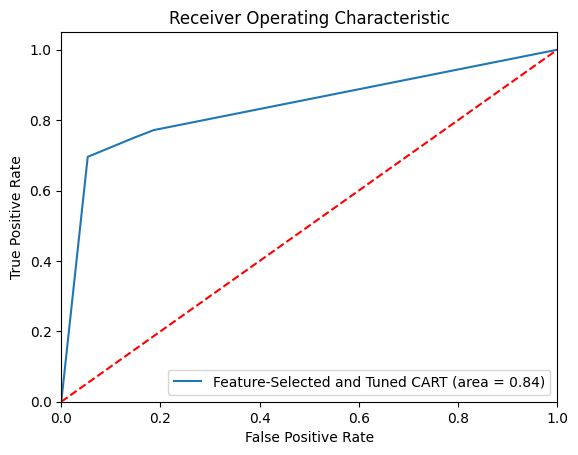

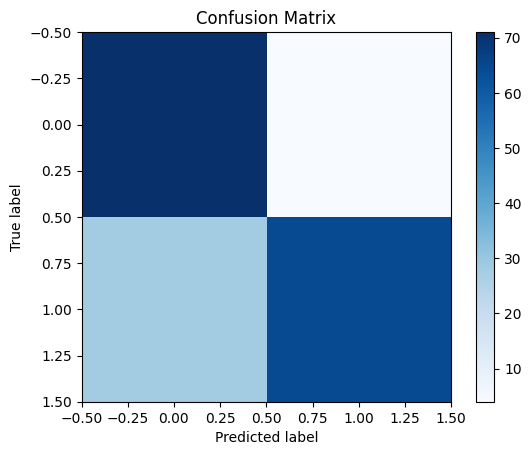

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(DecisionTreeClassifier(random_state=42))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize Decision Tree Classifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Parameter grid
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [10, 20, 30],
              'min_samples_split': [2, 5, 10]}

# Initialize GridSearchCV
grid_search = GridSearchCV(cart_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of feature-selected and tuned CART: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned CART (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# ANN updated

Accuracy of ANN: 0.7245508982035929
ROC-AUC Score: 0.7702898550724637


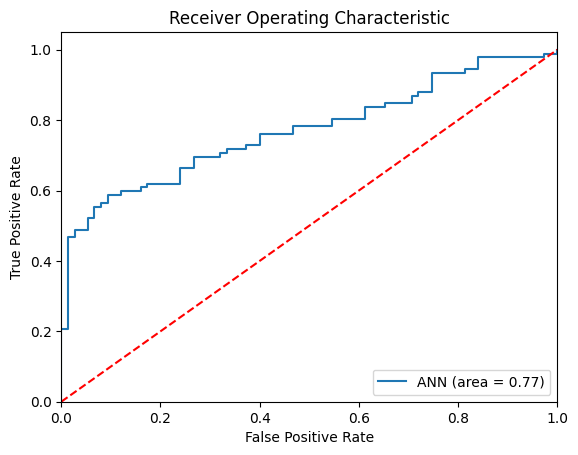

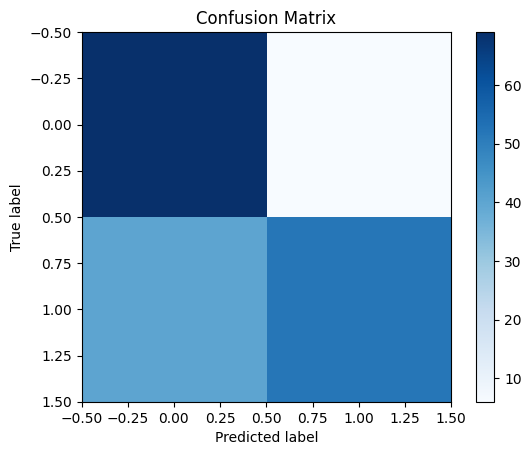

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize ANN
ann_model = MLPClassifier()

# Fit the model
ann_model.fit(X_train, y_train)

# Make predictions
y_pred = ann_model.predict(X_test)
y_pred_proba = ann_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of ANN: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ANN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**ANN_GS**

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of Tuned ANN: 0.718562874251497
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (30,)}
ROC-AUC Score: 0.7702898550724637


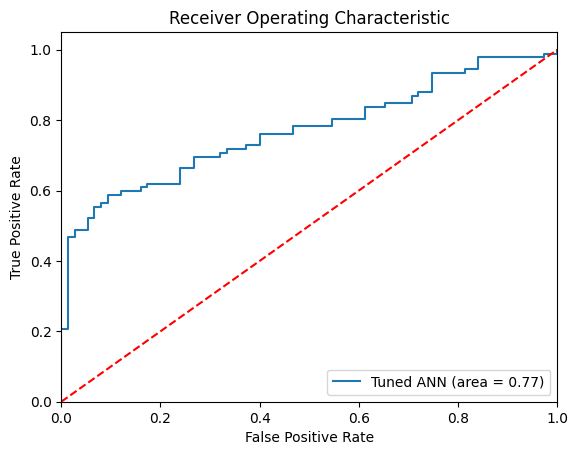

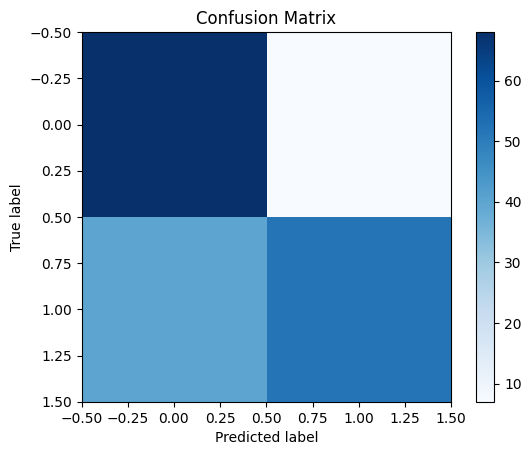

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize ANN
ann_model = MLPClassifier()

# Parameter grid
param_grid = {'hidden_layer_sizes': [(10,), (20,), (30,)], 'activation': ['relu', 'tanh']}

# Initialize GridSearchCV
grid_search = GridSearchCV(ann_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of Tuned ANN: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Tuned ANN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**ANN_FS_GS**

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of Feature-Selected and Tuned ANN: 0.7245508982035929
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10,)}
ROC-AUC Score: 0.7702898550724637


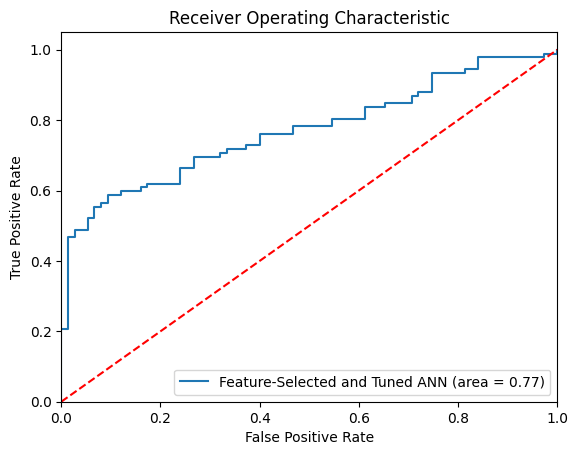

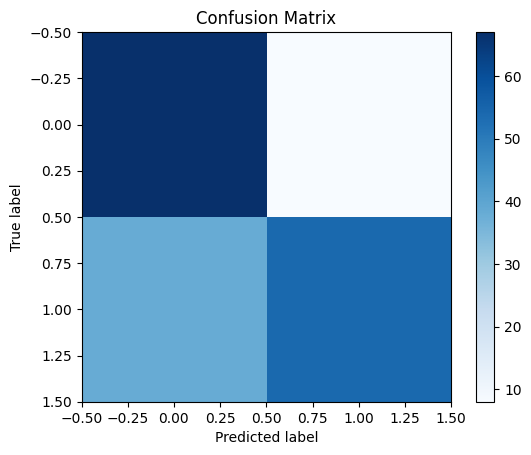

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize ANN
ann_model = MLPClassifier()

# Parameter grid
param_grid = {'hidden_layer_sizes': [(10,), (20,), (30,)], 'activation': ['relu', 'tanh']}

# Initialize GridSearchCV
grid_search = GridSearchCV(ann_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of Feature-Selected and Tuned ANN: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned ANN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Logistic Regression updated

Accuracy of Logistic Regression: 0.7245508982035929
ROC-AUC Score: 0.7702898550724637


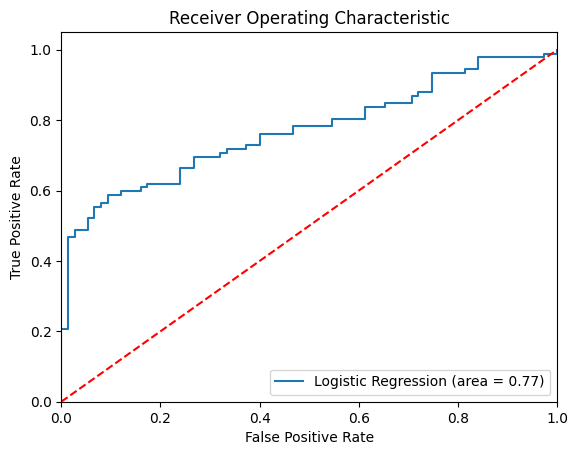

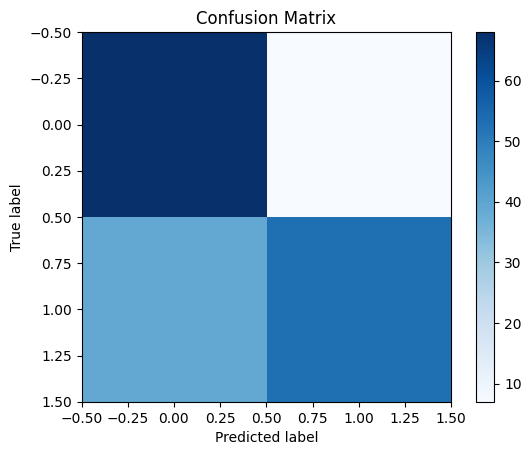

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42)

# Fit the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of Logistic Regression: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**Logistic Regression with GS**

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

Accuracy of tuned Logistic Regression: 0.7065868263473054
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC Score: 0.7702898550724637


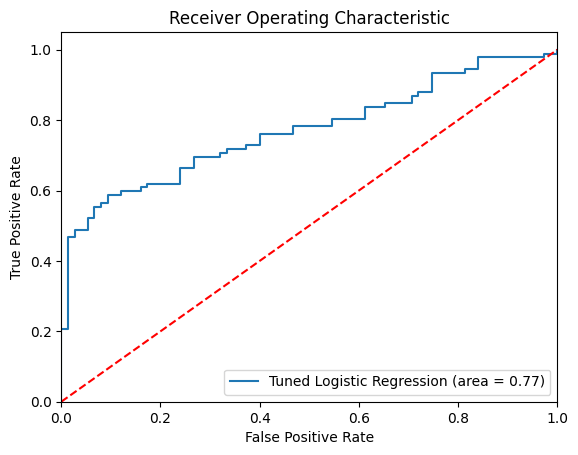

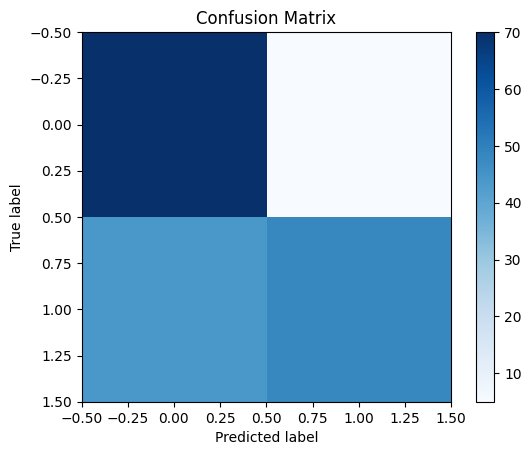

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42)

# Parameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Initialize GridSearchCV
grid_search = GridSearchCV(lr_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of tuned Logistic Regression: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Tuned Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**Logistic Regression with FS & GS**

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

Accuracy of feature-selected and tuned Logistic Regression: 0.7065868263473054
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC Score: 0.7702898550724637


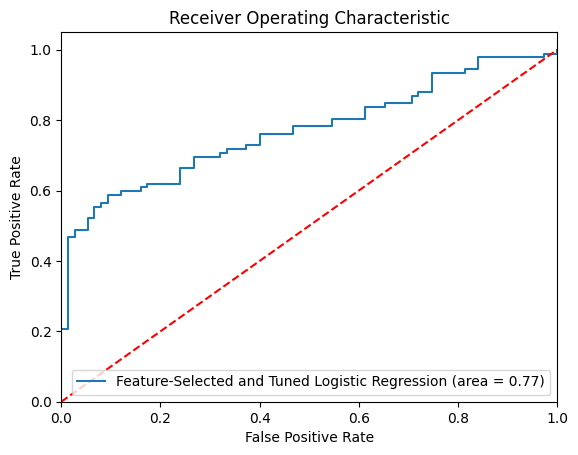

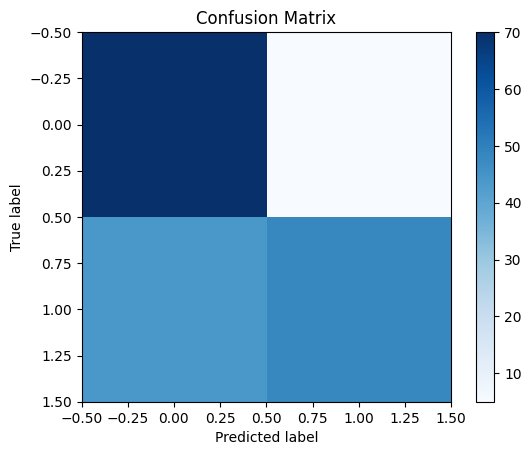

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(LogisticRegression(random_state=42))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42)

# Parameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Initialize GridSearchCV
grid_search = GridSearchCV(lr_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of feature-selected and tuned Logistic Regression: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# SVM updated

Accuracy of SVM: 0.7125748502994012
ROC-AUC Score: 0.7689855072463768


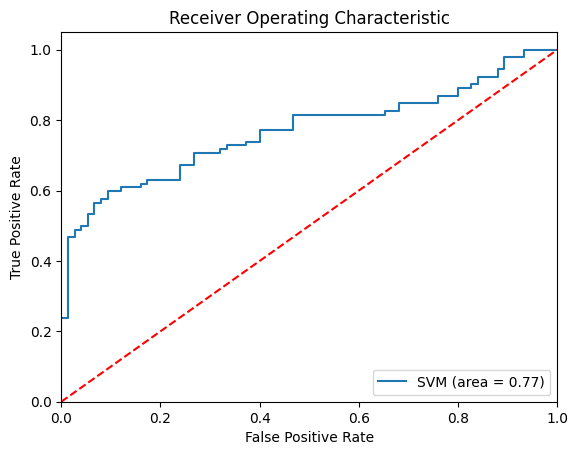

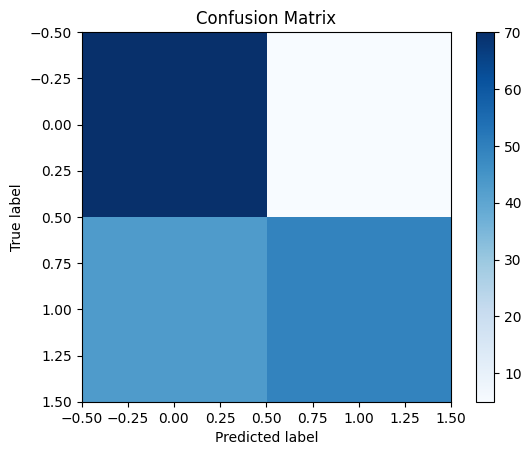

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize SVM
svm_model = SVC(probability=True, random_state=42)

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of SVM: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**SVM_GS**

Accuracy of tuned SVM: 0.7125748502994012
Best Parameters: {'C': 10, 'kernel': 'rbf'}
ROC-AUC Score: 0.7750724637681159


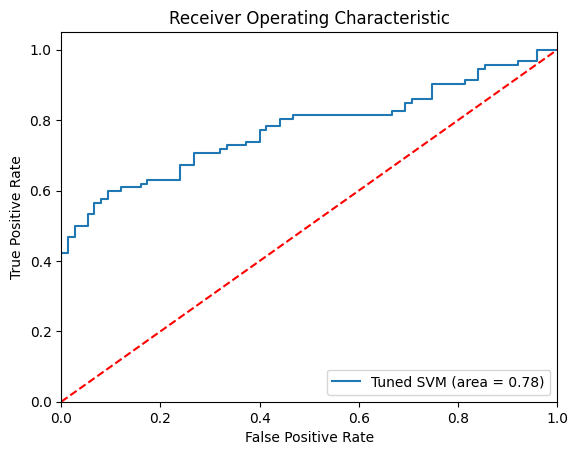

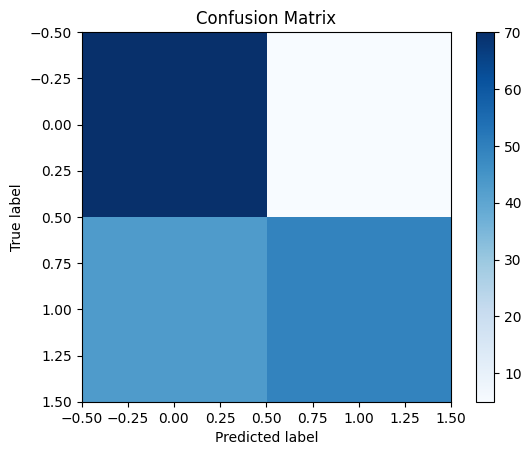

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize SVM
svm_model = SVC(probability=True, random_state=42)

# Parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of tuned SVM: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Tuned SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**SVM_FS_GS**

Accuracy of feature-selected and tuned SVM: 0.7125748502994012
Best Parameters: {'C': 10, 'kernel': 'rbf'}
ROC-AUC Score: 0.7750724637681159


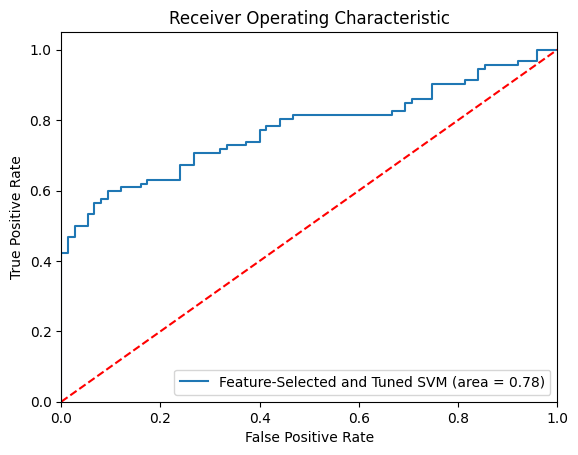

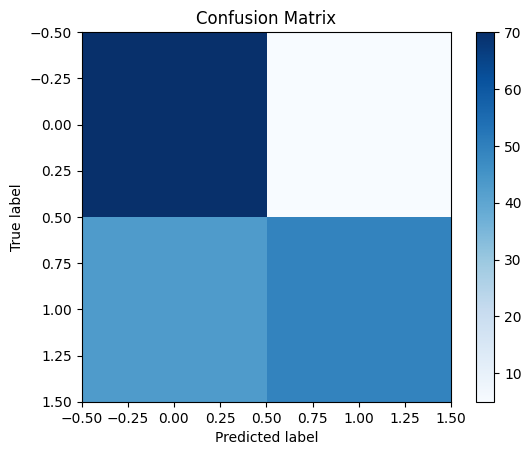

Accuracy of feature-selected and tuned SVM: 0.7125748502994012
Best Parameters: {'C': 10, 'kernel': 'rbf'}
ROC-AUC Score: 0.7750724637681159


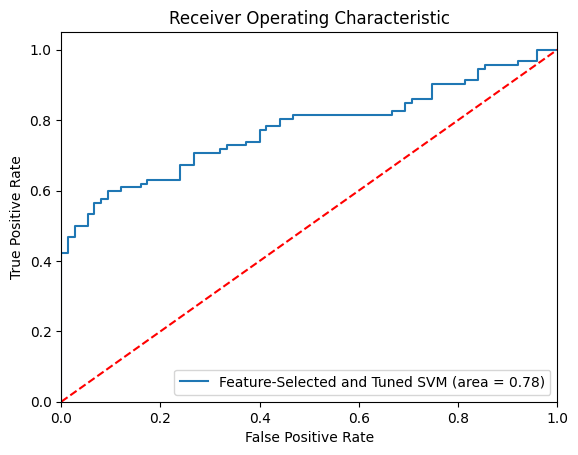

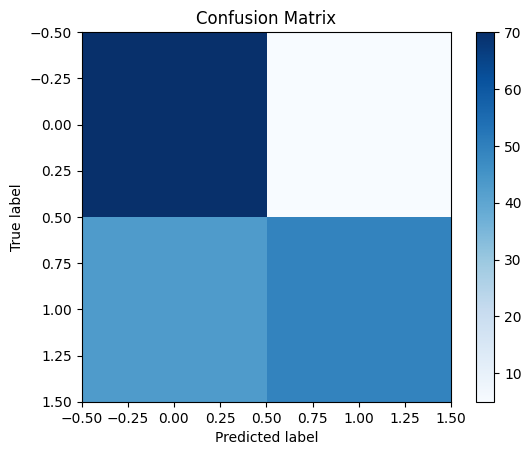

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(SVC(kernel='linear', probability=True, random_state=42))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize SVM
svm_model = SVC(probability=True, random_state=42)

# Parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of feature-selected and tuned SVM: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(SVC(kernel='linear', probability=True, random_state=42))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize SVM
svm_model = SVC(probability=True, random_state=42)

# Parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of feature-selected and tuned SVM: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# KNN updated

Accuracy of KNN: 0.7544910179640718
ROC-AUC Score: 0.8193478260869567


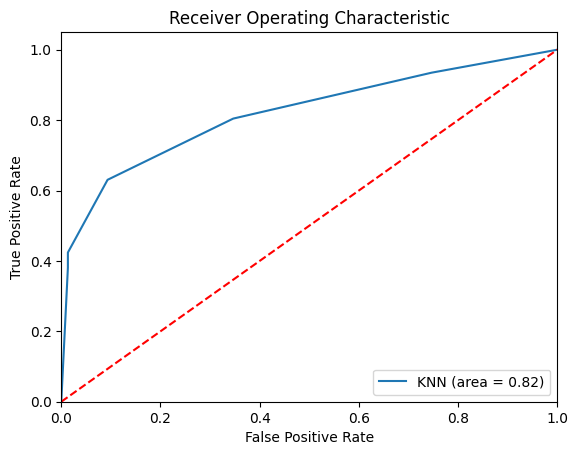

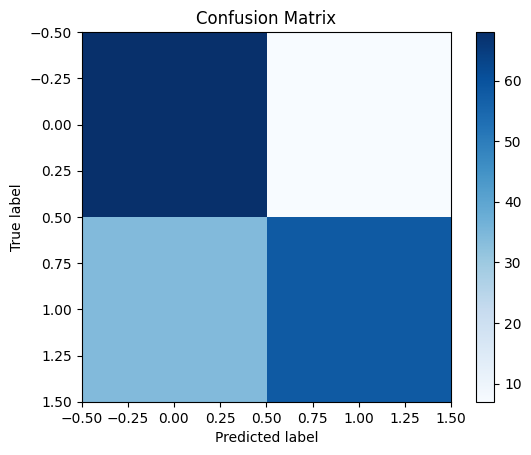

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize KNN
knn_model = KNeighborsClassifier()

# Fit the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of KNN: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**KNN_GS**

Accuracy of tuned KNN: 0.7065868263473054
Best Parameters: {'n_neighbors': 7}
ROC-AUC Score: 0.8092753623188406


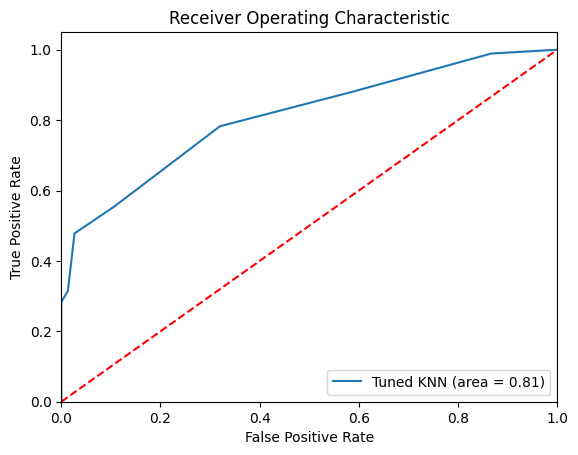

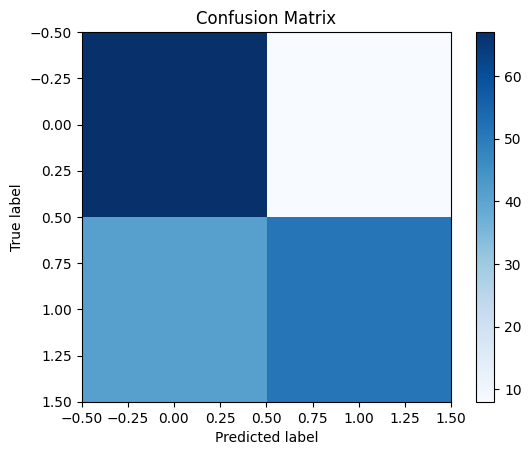

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize KNN
knn_model = KNeighborsClassifier()

# Parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of tuned KNN: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Tuned KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**KNN_FS_GS**

Accuracy of feature-selected and tuned KNN: 0.7065868263473054
Best Parameters: {'n_neighbors': 7}
ROC-AUC Score: 0.8092753623188406


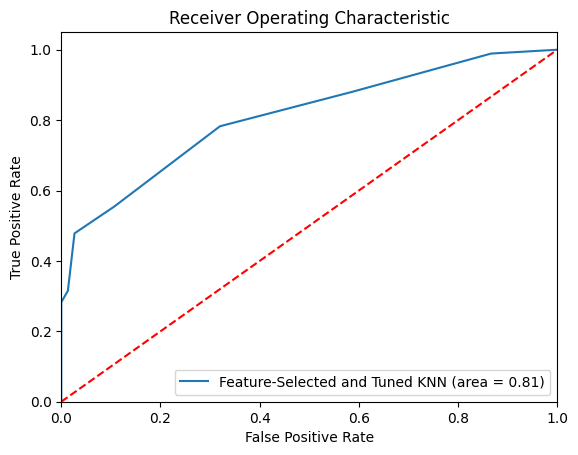

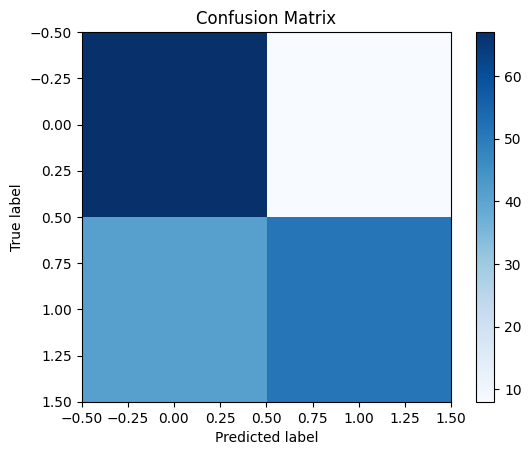

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize KNN
knn_model = KNeighborsClassifier()

# Parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of feature-selected and tuned KNN: {accuracy}")
print(f"Best Parameters: {best_params}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected and Tuned KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Gaussian Naive Bayes updated

Accuracy of GaussianNB: 0.7005988023952096
ROC-AUC Score: 0.7426086956521739


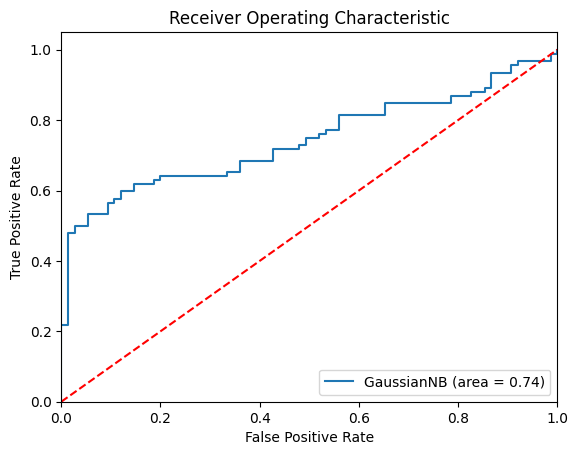

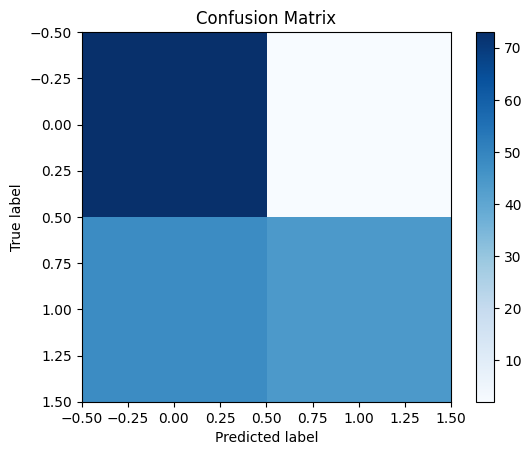

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Initialize GaussianNB
gnb_model = GaussianNB()

# Fit the model
gnb_model.fit(X_train, y_train)

# Make predictions
y_pred = gnb_model.predict(X_test)
y_pred_proba = gnb_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of GaussianNB: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='GaussianNB (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


**GNB_FS**

Accuracy of Feature-Selected GaussianNB: 0.7005988023952096
ROC-AUC Score: 0.7426086956521739


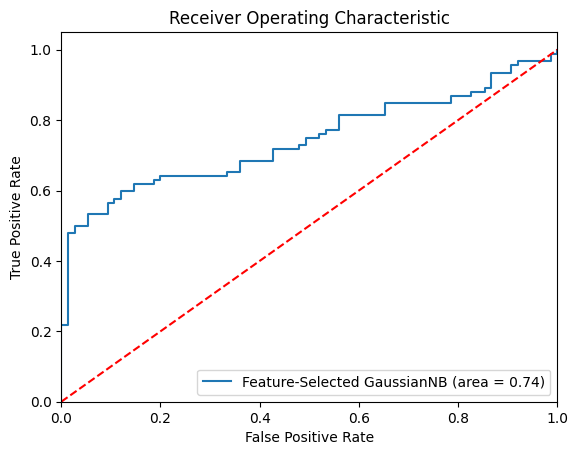

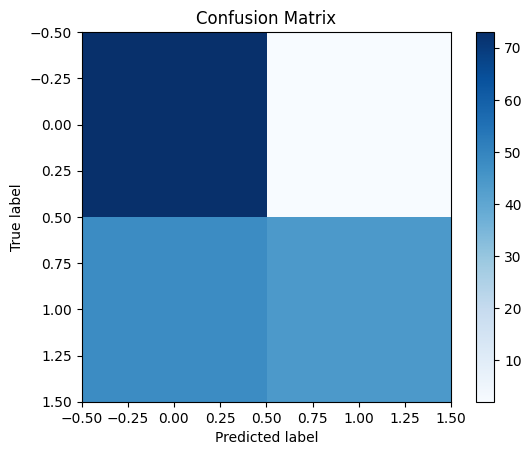

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Initialize GaussianNB
gnb_model = GaussianNB()

# Fit the model
gnb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = gnb_model.predict(X_test_selected)
y_pred_proba = gnb_model.predict_proba(X_test_selected)[:, 1]

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy of Feature-Selected GaussianNB: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Feature-Selected GaussianNB (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Stacking updated

**Stacking_GS**

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0

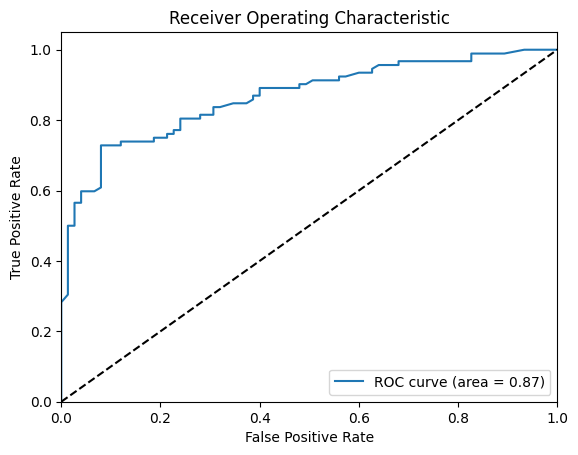

Confusion Matrix: 
[[66  9]
 [25 67]]


In [36]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

# Further split the training set to create a meta-training set
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Define the base models
base_models = [
    ('xgb', XGBClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=42)

# Create the Stacking Classifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define parameter grid to search
param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__learning_rate': [0.01, 0.1],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [10, 20],
    'cart__max_depth': [10, 20],
    'final_estimator__C': [0.1, 1.0]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=stacking_classifier, param_grid=param_grid, cv=5)

# Fit the grid search model
grid_search.fit(X_train_base, y_train_base)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions using the best model
y_pred = best_estimator.predict(X_test)
y_prob = best_estimator.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned Stacking Classifier: {accuracy}")

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{conf_matrix}")
